# Activité : Sélectionnez le nombre de voisins dans un kNN pour une régression

## 1/ Chargement et préparation des jeux de données

Le dataset utilisé est celui des vins rouges 'winequality-red'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection, dummy, preprocessing, neighbors, metrics

data = pd.read_csv('winequality-red.csv', sep=";")

X = data.as_matrix(data.columns[:-1])
y = data.as_matrix([data.columns[-1]])
y = y.flatten()

X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, 
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

## 2/ Création d'une classe qui pourra trouver le meilleur hyper-paramètre à l'aide d'une Grid Search

In [2]:
class KnnGridSearchCV:
    """
    Classe qui permet de faire une Grid Search pour trouver le meilleur hyperparamètre d'un modèle
    de type kNN sur un problème de régression.
    
    Elle s'utilise de la manière suivante:
    . Initialisation avec la liste des hyper-paramètres à tester et le nombre de folds.
    . Fonction 'fit' qui va réaliser la validation croisée, retourner les résultats.
    . Fonction 'predict' qui va entraîner le modèle avec le meilleur résultat de la fonction fit, 
        puis retourner les prédictions sur un jeu de test. 
    """

    def __init__(self, param_grid, nb_folds):
        """
        Initialisation de la classe.

        Prend en paramètres uniquement la liste des hyperparamètres et le nombre de folds
        """

        self.skf = model_selection.KFold(nb_folds) 
        self.params = param_grid

    def fit(self, X, y):
        """
        Teste les différents hyperparamètres sur le jeu de données (X, y)
        
        Prends en paramètres les jeux d'entraînement X et y.
        Ne retourne rien mais enregistre les résultats dans cv_results_ et best_params_
        """
        
        self.mse = [[] for _ in self.params]  # Enregistre les MSE de chaque paramètre pour chaque fold
        self.r2 = [[] for _ in self.params]   # Pareil mais avec les R2
        self.cv_results_ = {}   # Pour enregistrer les résultats à la fin

        # Stockage du jeu de données pour être réutilisé dans la fonction predict
        self.X_train = X
        self.y_train = y

        for train_idx, test_idx in self.skf.split(X, y):    # La 1e boucle parcoure les différents folds
            for idx, param in enumerate(self.params):   # La 2e boucle teste chaque param sur un fold
                knn = neighbors.KNeighborsRegressor(param)
                knn.fit(X[train_idx], y[train_idx])
                self.r2[idx].append(knn.score(X[test_idx], y[test_idx]))
                self.mse[idx].append(metrics.mean_squared_error(y[test_idx], knn.predict(X[test_idx])))

        # Pour chaque hyper-paramètre, on garde la moyenne, l'écart-type (pour MSE et R2) 
        # et la valeur du paramètre
        self.cv_results_['mean_test_mse'] = [np.mean(self.mse[i]) for i in range(len(self.params))]
        self.cv_results_['std_test_mse'] = [np.std(self.mse[i]) for i in range(len(self.params))]
        self.cv_results_['mean_test_r2'] = [np.mean(self.r2[i]) for i in range(len(self.params))]
        self.cv_results_['std_test_r2'] = [np.std(self.r2[i]) for i in range(len(self.params))]
        self.cv_results_['params'] = [self.params[i] for i in range(len(self.params))]

        # Le meilleur choisi est celui qui a le MSE le plus faible.
        self.best_params_ = self.cv_results_['params'][np.argmin(self.cv_results_['mean_test_mse'])]

    def predict(self, X):
        """
        Fait des prédictions sur le jeu de données X en utilisant le meilleur
        hyperparamètres trouvé avec la fonction fit.
        
        Prends en paramètre le jeu de test sur lequel faire les prédictions.
        Retourne les prédictions.
        """

        knn = neighbors.KNeighborsClassifier(self.best_params_)
        knn.fit(self.X_train, self.y_train)

        return knn.predict(X)


## 3/ Recherche du meilleur paramètre et affichage des résultats de MSE et R2 en fonction de k (l'hyper-paramètre recherché)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
45


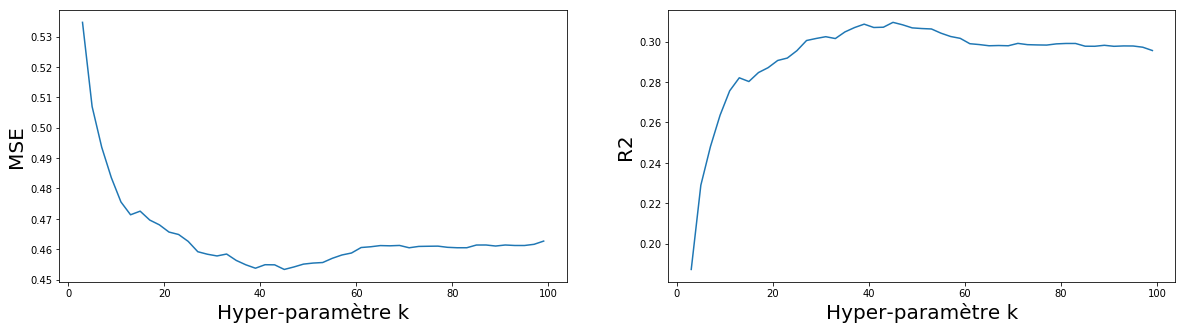

In [3]:
param_grid = [i for i in range(3, 100, 2)]  # La liste des hyper-paramètres à tester

regr = KnnGridSearchCV(param_grid, nb_folds=5)
regr.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(regr.best_params_)

# Partie falcultative: enlever les commentaires si vous souhaitez voir les 
# résultats en détail pour chaque paramètre
"""
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(regr.cv_results_['mean_test_mse'], # score moyen
regr.cv_results_['std_test_mse'], # écart-type du score
regr.cv_results_['params'] # valeur de l'hyperparamètre
):
    print("\t%s = %0.3f (+/-%0.03f) for %r" % (
        "MSE", # critère utilisé 
        mean, # score moyen 
        std * 2, # barre d'erreur 
        params # hyperparamètre 
        ))
    
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(regr.cv_results_['mean_test_r2'], # score moyen
regr.cv_results_['std_test_r2'], # écart-type du score
regr.cv_results_['params'] # valeur de l'hyperparamètre
):
    print("\t%s = %0.3f (+/-%0.03f) for %r" % (
        "R2", # critère utilisé 
        mean, # score moyen 
        std * 2, # barre d'erreur 
        params # hyperparamètre 
        ))
"""

# Création des graphiques qui permettent d'observer les évolutions du MSE et du R2 en fonction de k
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(regr.cv_results_['params'], regr.cv_results_['mean_test_mse'])
plt.xlabel("Hyper-paramètre k", fontsize=20)
plt.ylabel("MSE", fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(regr.cv_results_['params'], regr.cv_results_['mean_test_r2'])
plt.xlabel("Hyper-paramètre k", fontsize=20)
plt.ylabel("R2", fontsize=20)

plt.show()

### Observations: Les courbes du MSE et du R2 sont inversées et possèdent la même valeur optimale. En effet, le minimum du MSE s'observe pour le même 'k' que le maximum de R2. Les deux paramètres peuvent être utilisés pour choisir le 'k' optimal (ici j'ai utilisé le MSE).

## 4/ Entraînement du modèle avec le meilleur 'k' et comparaison des résultats avec des modèles naïfs.

Ici, on comparera le MSE et le R2 du modèle kNN avec 2 autres modèles naïfs:

_ un modèle aléatoire (y_pred_random)

_ un modèle constant (y_pred_dummy) qui sera toujours égal à la moyenne du jeu d'entraînement.

In [4]:
# Prédiction des résultats avec notre 'k' optimal
y_pred = regr.predict(X_test_std)

# Prédiction des résultats dans le cas aléatoire
y_pred_random = np.random.randint(np.min(y_train), np.max(y_train), y_test.shape)

# Prédiction des résultats dans le cas constant
dum = dummy.DummyRegressor(strategy='mean')
dum.fit(X_train_std, y_train)
y_pred_dummy = dum.predict(X_test_std)

# Affichage des résultats dans un tableau pour comparaison
results = pd.DataFrame({
    'MSE': [metrics.mean_squared_error(y_test, y_pred),
            metrics.mean_squared_error(y_test, y_pred_dummy),
            metrics.mean_squared_error(y_test, y_pred_random)],
    'R2': [metrics.r2_score(y_test, y_pred),
           metrics.r2_score(y_test, y_pred_dummy),
           metrics.r2_score(y_test, y_pred_random)]
}, index=('kNN', 'Dummy (constante)', 'Random'))
print(results)

                        MSE        R2
kNN                0.510417  0.193277
Dummy (constante)  0.633643 -0.001483
Random             2.797917 -3.422157


### Conclusion: Le modèle kNN fait beaucoup mieux que le modèle aléatoire (Random) et un peu mieux que le modèle constant (Dummy). Ce qui concorde avec les résultats obtenus lors du TP. 